# Dense Convolutional AE (DCAE)

In this notebook I am testing CAE combined with several densely connected layers on 1D data tracks.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 12000
step_size = window_size / 2
aggregation = 100

chroms = [
    # Training
    'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
    'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
    # Testing
    'chr16', 'chr17', 'chr18', 'chr19', 'chr20',  'chr21', 'chr22', 'chrX'
]

## Load, merge, normalize, and filter data

#### Retrieved binned genomic windows

In [3]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data...')

# GM12878 DNase-seq read-depth normalized signal
bw1 = 'data/ENCFF158GBQ.bigWig'
if not Path(bw1).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF158GBQ/@@download/ENCFF158GBQ.bigWig',
        'data/ENCFF158GBQ.bigWig',
    )

# GM12878 ChIP-seq H3K27ac log10 p-val
bw2 = 'data/ENCFF258KTL.bigWig'
if not Path(bw2).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF258KTL/@@download/ENCFF258KTL.bigWig',
        'data/ENCFF258KTL.bigWig',
    )

print('Done!')

Download data...
Done!


In [88]:
from ae import bigwig

data = bigwig.chunk(
    bw1,
    window_size,
    step_size,
    aggregation,
    chroms,
    verbose=True,
)

Chrom: chr1 # win: 41541 Max:   84.65786437988281
Chrom: chr2 # win: 40533 Max:   34.59584045410156
Chrom: chr3 # win: 33003 Max:   754.708974942565
Chrom: chr4 # win: 31859 Max:   85.05682714376599
Chrom: chr5 # win: 30152 Max:   41.60652942657471
Chrom: chr6 # win: 28519 Max:   40.123119831085205
Chrom: chr7 # win: 26523 Max:   92.87817115783692
Chrom: chr8 # win: 24394 Max:   51.1911699295044
Chrom: chr9 # win: 23535 Max:   12.23145271539688
Chrom: chr10 # win: 22589 Max:   27.89546957015991
Chrom: chr11 # win: 22501 Max:   20351.5005859375
Chrom: chr12 # win: 22308 Max:   38.03064985275269
Chrom: chr13 # win: 19194 Max:   17.129234886169435
Chrom: chr14 # win: 17891 Max:   12.31135447025299
Chrom: chr15 # win: 17088 Max:   16.326660537719725
Chrom: chr16 # win: 15059 Max:   28.12018985748291
Chrom: chr17 # win: 13532 Max:   38.36367921829223
Chrom: chr18 # win: 13012 Max:   33.154639625549315
Chrom: chr19 # win: 9854 Max:   32.29303021989763
Chrom: chr20 # win: 10504 Max:   32.1133

#### Merge the binned windows into one training and test set

In [89]:
num_training = 15

train_num = 0
test_num = 0

for i in range(num_training):
    train_num += data[i].shape[0]

for i in range(num_training, len(data)):
    test_num += data[i].shape[0]
    
data_train = np.zeros((train_num, window_size // aggregation))
data_test = np.zeros((test_num, window_size // aggregation))

k = 0
for i in range(num_training):
    l = k + data[i].shape[0]
    data_train[k:l,] = data[i]
    k = l

k = 0
for i in range(num_training, len(data)):
    l = k + data[i].shape[0]
    data_test[k:l,] = data[i]
    k = l

#### Cap at 99.9th percentile and normalize to `[0,1]`

In [90]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cutoff = np.percentile(data_train, (0, 99.9))
data_train_norm = np.copy(data_train)
data_train_norm[np.where(data_train_norm < cutoff[0])] = cutoff[0]
data_train_norm[np.where(data_train_norm > cutoff[1])] = cutoff[1]

cutoff = np.percentile(data_test, (0, 99.9))
data_test_norm = np.copy(data_test)
data_test_norm[np.where(data_test_norm < cutoff[0])] = cutoff[0]
data_test_norm[np.where(data_test_norm > cutoff[1])] = cutoff[1]

# print(
#     'Train Max: {}'.format(np.max(data_train_norm)),
#     'Test Max:  {}'.format(np.max(data_test_norm)),
# )

data_train_norm = MinMaxScaler().fit_transform(data_train_norm)
data_test_norm = MinMaxScaler().fit_transform(data_test_norm)

Train Max: 1.3120553496331 Test Max:  1.9597131899179732


#### Visualize distribution of genomic windows by their sum

**Training data:**

401630 338029


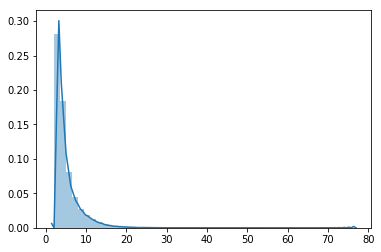

In [91]:
import seaborn as sns
sum_thresh = 2
dsum = np.sum(data_train_norm, axis=1)
sns.distplot(dsum[np.where(dsum > 2)])
print(
    '{} out of {} 12Kb windows have a total signal above {}.'.format(
        dsum[np.where(dsum > sum_thresh)].size, dsum.size, sum_thresh
    )
)

**Test data:**

104410 65745


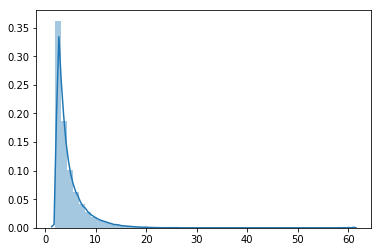

In [92]:
import seaborn as sns
dsum = np.sum(data_test_norm, axis=1)
sns.distplot(dsum[np.where(dsum > 2)])
print(dsum.size, dsum[np.where(dsum > 2)].size)

#### Filter data

In [ ]:
threshold = 5

train_sum = np.sum(data_train_norm, axis=1)
final_train = data_train_norm[np.where(train_sum > threshold)]

test_sum = np.sum(data_test_norm, axis=1)
final_test = data_test_norm[np.where(test_sum > threshold)]

print(data_train_norm.shape[0], final_train.shape[0], data_test_norm.shape[0], final_test.shape[0])

## Define DCAEs

In [99]:
from ae.cnn import cnn3

num_setups = 1

setups = {
    "cfilters": [[256, 64]],
    "ckernel_sizes": [[13, 9]],
    "dunits": [[1920, 1920, 1920, 512, 64, 16]],
    "embedding": [10] * num_setups,
    "dropouts": [[0, 0, 0, 0.5, 0.5, 0, 0, 0]],
    "reg_lambda": [0] * num_setups,
    "loss": ['binary_crossentropy'] * num_setups,
    "epochs": [25] * num_setups,
}

ens = []
des = []
aes = []

for i in range(num_setups):
    en, de, ae = cnn3(
        window_size // aggregation,
        cfilters=setups['cfilters'][i],
        ckernel_sizes=setups['ckernel_sizes'][i],
        dunits=setups['dunits'][i],
        embedding=setups['embedding'][i],
        dropouts=setups['dropouts'][i],
        loss=setups['loss'][i],
        reg_lambda=setups['reg_lambda'][i],
        metrics=['accuracy'],
        summary=False,
    )
    ens.append(en)
    des.append(de)
    aes.append(ae)

## Train DCAEs

In [ ]:
from ae.utils import train

for i in range(num_setups):
    train(
        aes[i],
        final_train.reshape(final_train.shape[0], final_train.shape[1], 1),
        final_test.reshape(final_test.shape[0], final_test.shape[1], 1),
        epochs=setups['epochs'][i],
        batch_size=256,
    )

## Save DCAE models

In [85]:
# ens[0].save('../data/models/encode-gm12878-chip-seq-h3k27ac-pval-2011-encoder-dcae.h5')
# des[0].save('../data/models/encode-gm12878-chip-seq-h3k27ac-pval-2011-decoder-dcae.h5')
# aes[0].save('../data/models/encode-gm12878-chip-seq-h3k27ac-pval-2011-autoencoder-dcae.h5')

## Predict genomic windows

In [80]:
from keras.metrics import binary_crossentropy
from ae.utils import predict

predicteds = []
losses = []

for i in range(num_setups):
    predicted, loss, _ = predict(
        ens[i],
        des[i],
        data_test1_norm.reshape(data_test1_norm.shape[0], data_test1_norm.shape[1], 1),
        validator=binary_crossentropy
    )
    predicteds.append(predicted.reshape(predicted.shape[0], predicted.shape[1]))
    losses.append(loss)

0 3.8496897


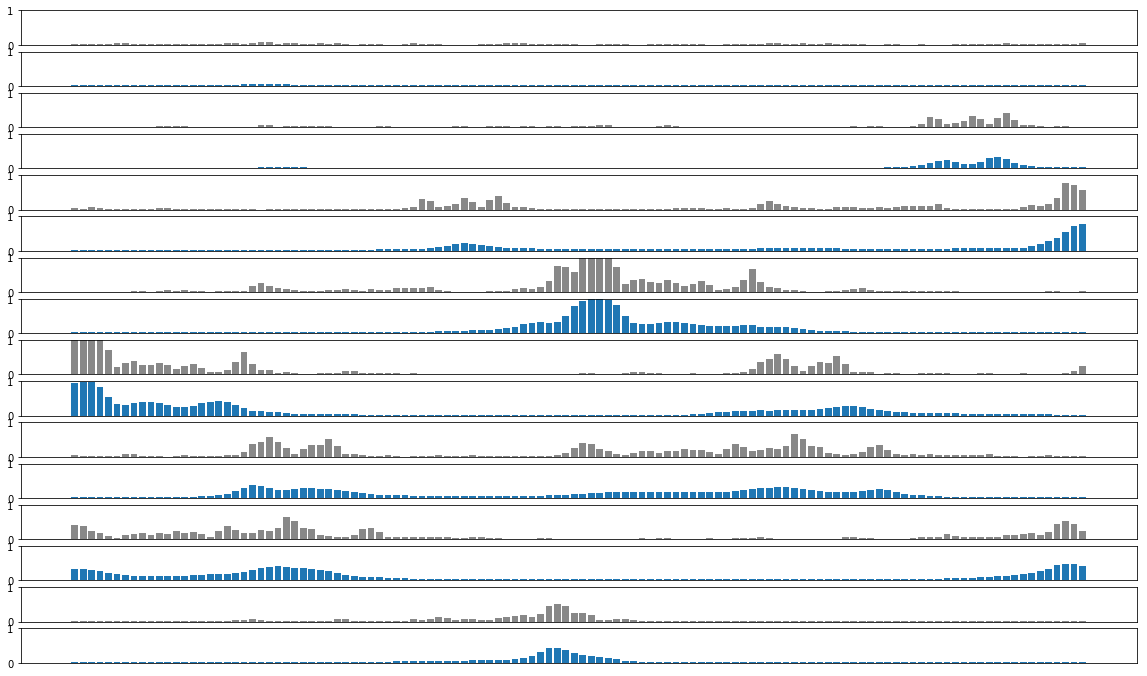

In [81]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')

n = 8
offset = 5920
offset = 5114
offset = 5335

ymax = 1.0

plt.figure(figsize=(20, n * (num_setups + 1) * 0.75))
for i in range(n):
    k = i + offset
    
    # display original
    ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 1) + 1)
    ax.set_facecolor('#ffffff')
    plt.bar(np.arange(data_test1_norm[k].size), data_test1_norm[k], color='#888888')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
    
    for j in range(num_setups):
        # display reconstruction
        ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 1) + j + 2)
        plt.bar(np.arange(predicteds[j][k].size), predicteds[j][k], color=cmap(j))
        plt.ylim(0, ymax)
        ax.get_xaxis().set_visible(False)
plt.show()

ValueError: num must be 1 <= num <= 24, not 25

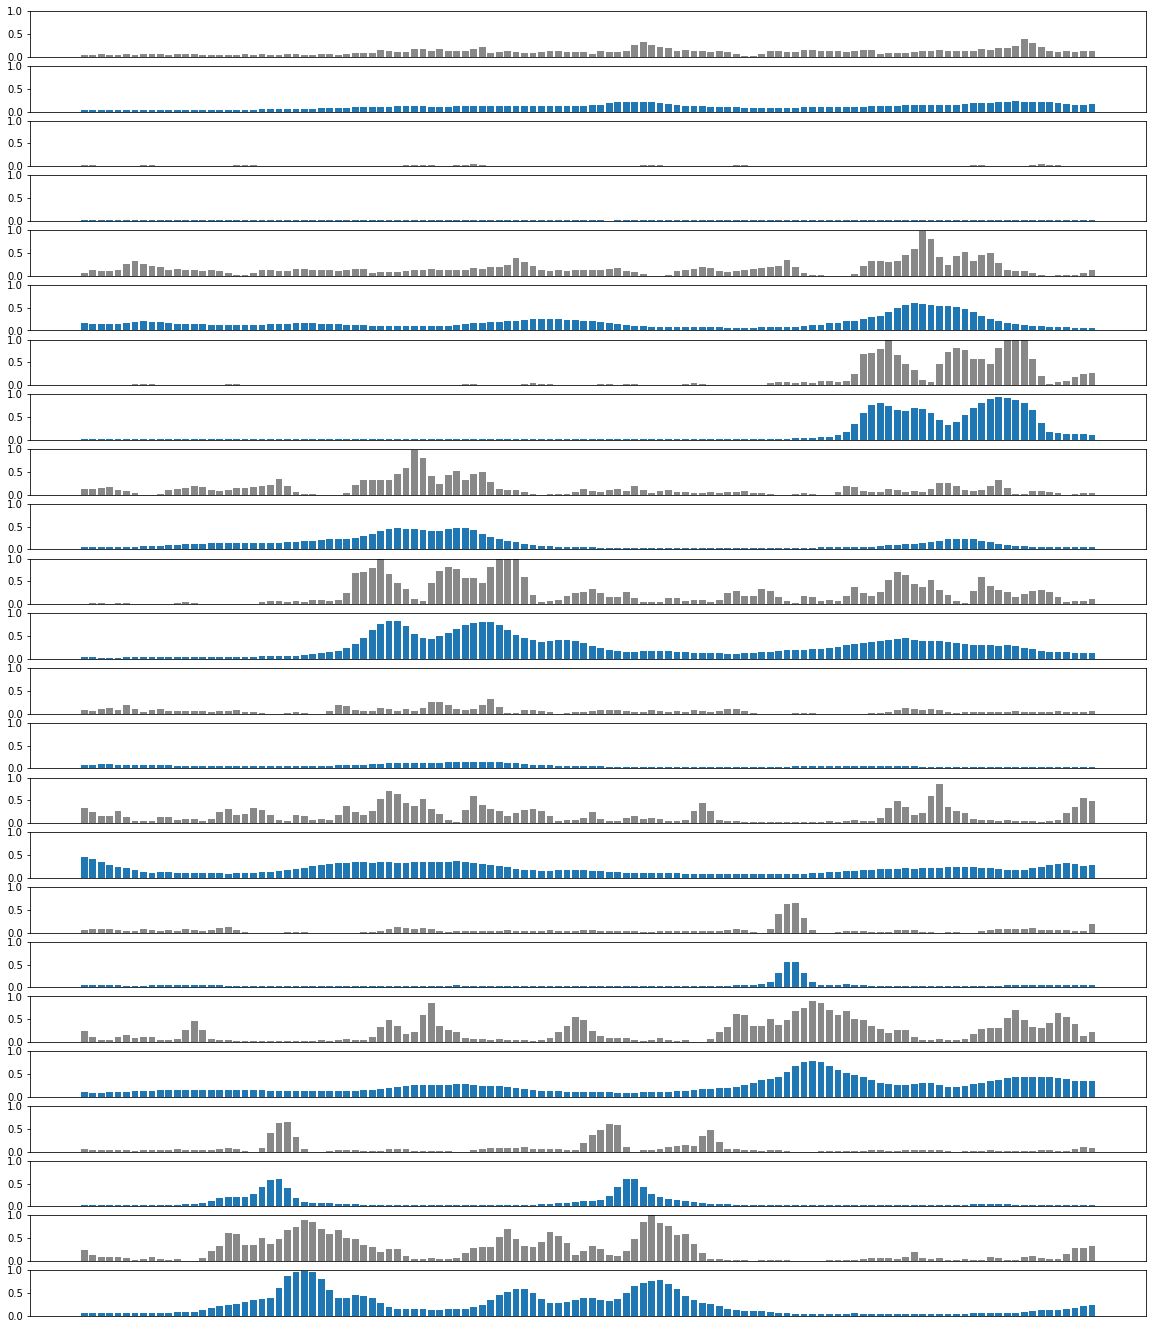

In [119]:
cmap = plt.get_cmap('tab10')

num_setups = 2
n = 8
offset = 5920
offset = 5114
offset = 5335
offset = 7050

offset_new = 6576

ymax = 1.0

plt.figure(figsize=(20, n * (num_setups + 2) * 0.75))
for i in range(n):
    k = i + offset
    
    # display original
    ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 2) + 1)
    ax.set_facecolor('#ffffff')
    plt.bar(np.arange(data1_test_norm[k].size), data1_test_norm[k], color='#888888')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 2) + 2)
    plt.bar(np.arange(predicteds[0][k].size), predicteds[0][k], color=cmap(0))
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 2) + 3)
    ax.set_facecolor('#ffffff')
    plt.bar(np.arange(data2_test_norm[k].size), data2_test_norm[k], color='#888888')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(n * (num_setups + 1), 1, i * (num_setups + 2) + 4)
    plt.bar(np.arange(predicteds[1][k].size), predicteds[1][k], color=cmap(0))
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
plt.show()